In [1]:
pip install torchcontrib

Note: you may need to restart the kernel to use updated packages.


In [ ]:

opt.swap_swa_sgd()
opt.bn_update(train_loader, model)

In [ ]:
opt = torchcontrib.optim.SWA(base_opt)

In [ ]:
   if i > 10 and i % 5 == 0:
        opt.update_swa()

In [1]:
from hw_grapheme.model_archs.se_resnext import se_resnext50
from hw_grapheme.io.load_model_weight import load_model_weight

In [2]:
import os 
import torch

import torch.optim as optim

from apex import amp
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from hw_grapheme.io.load_data import load_processed_data
from hw_grapheme.train_utils.train_test_split import stratified_split_kfold
from hw_grapheme.train_utils.create_dataloader import create_dataloaders_train
from hw_grapheme.model_archs.se_resnext import se_resnext50
from hw_grapheme.models.train import train_model

In [3]:
# load processed data 
pickle_paths = [
    "../data/processed/size_128/train_data_0.pickle",
#     "../data/processed/size_128/train_data_1.pickle",
#     "../data/processed/size_128/train_data_2.pickle",
#     "../data/processed/size_128/train_data_3.pickle",
]

image_data, name_data, label_data = load_processed_data(pickle_paths, image_size=128)

Load data done, shape: (50210, 128, 128), (50210,), (50210, 3)


In [27]:
import numpy as np

In [28]:
np.unique(image_data)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [22]:
image_data.max()

255

In [4]:
# split train valid set
n_splits = 5
random_seed = 2020

train_idx_list, test_idx_list = stratified_split_kfold(
    image_data, label_data, n_splits, random_seed
)

StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)


In [5]:
# create data_transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        # transforms.RandomAffine(degrees=10, scale=(1.0, 1.15)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        # transforms.Normalize([0.0692], [0.2051]),
        # transforms.ToPILImage(),
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        # transforms.Normalize([0.0692], [0.2051])
    ]),
}

In [6]:
# default training setting
num_workers = 6
pin_memory = True
fold = [0]

# customize training setting
n_epoch = 48
batch_size = 256
mixed_precision = True

model_func = se_resnext50
model_parameter = {}

optimizer = optim.Adam
optimizer_parameter = {"weight_decay": 1e-5}

mixup_alpha = 0.4  # for mixup/cutmix only
wandb_log = True

# prob. of using ["mixup", "cutmix", "cross_entropy"] loss
train_loss_prob = [0.0, 0.0, 1.0]

# weighting of [root, vowel, consonant]
head_loss_weight = [0.5, 0.25, 0.25]

# save dir, set None to not save, need to manual create folders first
save_dir = "../models/baseline_senext50/"

In [94]:
model = se_resnext50()
load_model_weight(model, "../models/baseline_resnext50/fold_0/high_recall_model.pth")

In [8]:
model

SeResNeXt(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (selayer): Selayer(
        (global_avgpool): AdaptiveAvgPool2d(output_size=1)
        (conv1): Conv2d(2

In [9]:
for i, (train_idx, valid_idx) in enumerate(zip(train_idx_list, test_idx_list)):
    data_loaders = create_dataloaders_train(
    image_data, name_data, label_data, train_idx, valid_idx, 
    data_transforms, batch_size, num_workers, pin_memory)

Creating train dataloader...
Creating valid dataloader...
Creating train dataloader...
Creating valid dataloader...
Creating train dataloader...
Creating valid dataloader...
Creating train dataloader...
Creating valid dataloader...
Creating train dataloader...
Creating valid dataloader...


In [10]:
ls = []
y1_ls = []
y2_ls = []
y3_ls = []
y1_pred_ls = []
y2_pred_ls = []
y3_pred_ls = []


In [11]:
from tqdm import tqdm_notebook as tqdm

In [12]:
model = model.cuda()

In [16]:
for i in tqdm(data_loaders['train']):
    x,y1,y2,y3 = i 
    print(x.min())

/home/hugo/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)

In [ ]:
for i in tqdm(data_loaders['val']):
    x,y1,y2,y3 = i 
    with torch.no_grad():
        y_pred = model(x.cuda())
        y1_pred, y2_pred ,y3_pred = y_pred
#         import pdb
#         pdb.set_trace()
        y1_pred, y2_pred, y3_pred = map(lambda x:F.softmax(torch.tensor(x)).argmax(1), (y1_pred, y2_pred, y3_pred))
        y1_pred = y1_pred.detach().cpu().numpy()
        y2_pred = y2_pred.detach().cpu().numpy()
        y3_pred = y3_pred.detach().cpu().numpy()
        y1= y1.detach().cpu().numpy()
        y2=y2.detach().cpu().numpy()
        y3=y3.detach().cpu().numpy()
        
        ls.append(y_pred)
        y1_ls.append(y1)
        y2_ls.append(y2)
        y3_ls.append(y3)
        y1_pred_ls.append(y1_pred)
        y2_pred_ls.append(y2_pred)
        y3_pred_ls.append(y3_pred)

In [ ]:
import numpy as np
import sklearn
from sklearn.metrics import classification_report, precision_recall_fscore_support
import pandas as pd

def flatten(ls):
    array = np.array(ls)
    return np.hstack(array.tolist())

In [ ]:
y1_ls = flatten(y1_ls)
y2_ls = flatten(y2_ls)
y3_ls = flatten(y3_ls)
y1_pred_ls = flatten(y1_pred_ls)
y2_pred_ls = flatten(y2_pred_ls)
y3_pred_ls = flatten(y3_pred_ls)

In [ ]:
y_trues , y_preds = [y1_ls, y2_ls, y3_ls], [y1_pred_ls, y2_pred_ls, y3_pred_ls]

In [ ]:
for y_true, y_pred in zip(y_trues, y_preds):
    print(sklearn.metrics.recall_score(y_true, y_pred, average='macro', zero_division='warn'))
    

In [ ]:
def show_most_wrong(df,n=10):
    return df.sort_values('recall').head(10)

In [ ]:
for y_true, y_pred in zip(y_trues, y_preds):
    metrics = precision_recall_fscore_support(y_true, y_pred,average=None)
    precision, recall, fscore, support = metrics
    data = np.vstack([recall, support, precision, fscore]); data.shape    
    metrics_summary_df = pd.DataFrame(data=data.T, columns=['recall', 'support','precision','fscore'])
    metrics_summary_df = metrics_summary_df.sort_values('recall')
    print(show_most_wrong(metrics_summary_df))
    print("================= I am separation line ============")

# Interpret Module

In [65]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
# from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


In [154]:
class Interpret():
    def __init__(self, model):
        self.model = model
        model = models.resnet18(pretrained=True)
    model = model.eval()
    
    def __call__(self, image):
        """
        images: 3D image (Channel, Height , Width)
        """
        input = image.unsqueeze(0)
        output = model(input)
        output = tuple(map(lambda x: F.softmax(x), (output)))
        pred=tuple(map(lambda x: torch.topk(x,1), (b)))
        score1, idx1 =pred[0]
        score2, idx2 =pred[1]
        score3, idx3 =pred[2]
        prediction_score = (score1, score2, score3)
        pred_label_idx = (idx1, idx2, idx3)
        prediction_score =  tuple(map(lambda x:x.item(), prediction_score))
        pred_label_idx = tuple(map(lambda x:x.item(), pred_label_idx))
#         prediction_score, pred_label_idx = torch.topk(output, 3)
        print(f'Top Prediction Score: {prediction_score}, Label Index: {pred_label_idx}')
        pred_label_idx = np.array(pred_label_idx[0])
#         _, pred_label_idx = torch.topk(output, 1)
        torch.manual_seed(0)
        np.random.seed(0)

        gradient_shap = GradientShap(model)

        # Defining baseline distribution of images
        rand_img_dist = torch.cat([input * 0, input * 1])

        attributions_gs = gradient_shap.attribute(input,
                                                  n_samples=50,
                                                  stdevs=0.0001,
                                                  baselines=rand_img_dist,
                                                  target=pred_label_idx)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              ["original_image", "heat_map"],
                                              ["all", "absolute_value"],
                                              cmap=default_cmap,
                                              show_colorbar=True)

        return pred_label_idx

In [155]:
interpret = Interpret(model)

In [156]:
score = interpret(x[0])

/home/hugo/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Top Prediction Score: (0.11685864627361298, 0.5200185775756836, 0.9987842440605164), Label Index: (5, 1, 0)


AttributeError: 'tuple' object has no attribute 'shape'

# Model Inerpretation

In [31]:

import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
# from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz


# ## 1- Loading the model and the dataset
# 

# Loads pretrained Resnet model and sets it to eval mode

# In[2]:

In [90]:
model = models.resnet18(pretrained=True)
model = model.eval()


# Downloads the list of classes/labels for ImageNet dataset and reads them into the memory

# In[3]:


get_ipython().system('wget -P $HOME/.torch/models https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')


# In[4]:


labels_path = os.getenv("HOME") + '/.torch/models/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)


# Defines transformers and normalizing functions for the image.
# It also loads an image from the `img/resnet/` folder that will be used for interpretation purposes.

--2020-03-03 21:29:36--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.170.157
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.170.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/home/hugo/.torch/models/imagenet_class_index.json.5’

imagenet_class_inde 100%[===================>]  34.53K   157KB/s    in 0.2s    

2020-03-03 21:29:37 (157 KB/s) - ‘/home/hugo/.torch/models/imagenet_class_index.json.5’ saved [35363/35363]



In [ ]:

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

In [36]:
# In[5]:


transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [41]:
input = x[0].unsqueeze(0)

In [52]:
# In[6]:


output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

In [53]:
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: nematode ( 0.6630507707595825 )


In [54]:
# ## 2- Gradient-based attribution

# Let's compute attributions using Integrated Gradients and visualize them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class `pred_label_idx` with respect to the input image pixels along the path from the black image to our input image.

# In[7]:


print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

Predicted: nematode ( 0.6630507707595825 )


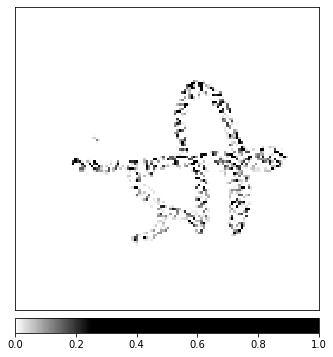

In [58]:
# Let's visualize the image and corresponding attributions by overlaying the latter on the image.

# In[8]:


default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

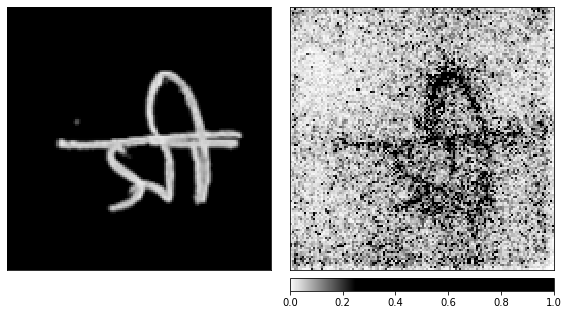

In [61]:
# Let us compute attributions using Integrated Gradients and smoothens them across multiple images generated by a <em>noise tunnel</em>. The latter adds gaussian noise with a std equals to one, 10 times (n_samples=10) to the input. Ultimately, noise tunnel smoothens the attributions across `n_samples` noisy samples using `smoothgrad_sq` technique. `smoothgrad_sq` represents the mean of the squared attributions across `n_samples` samples.

# In[9]:


noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(input, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)


# Finally, let us use `GradientShap`, a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

In [88]:
pred_label_idx = torch.tensor(3)

In [93]:
gradient_shap.attribute??

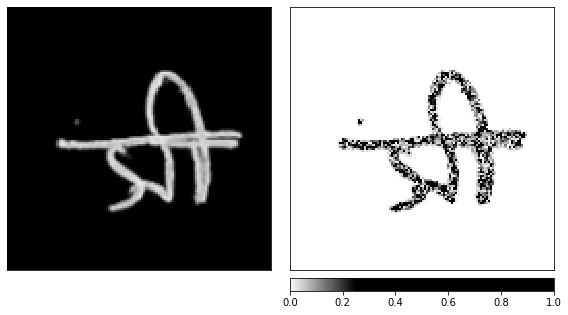

In [91]:
# In[10]:


torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)



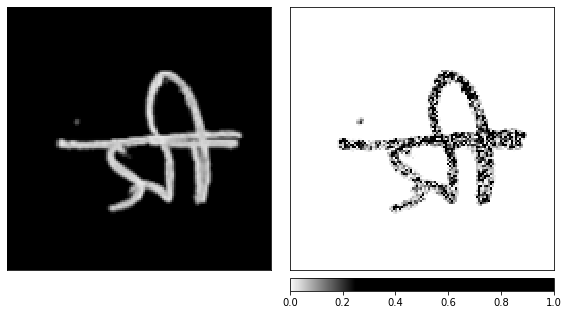

In [64]:
# In[10]:


torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])

attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)



In [63]:
# In[11]:


occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


# Let us visualize the attribution, focusing on the areas with positive attribution (those that are critical for the classifier's decision):

# In[12]:


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )


# The upper part of the goose, espectially the beak, seems to be the most critical for the model to predict this class.
# 
# We can verify this further by occluding the image using a larger sliding window:

# In[13]:


occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (3, 50, 50),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(3,60, 60),
                                       baselines=0)

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

NameError: name 'Occlusion' is not defined